# DESI PV Y1 $z$-bin TFR Calibration w/o zero-pointing

In redshift bins of width 0.001 (or 0.005), identify DESI observations with measurements suitable for the Tully-Fisher relation. Export the SGA IDs of the TFR galaxies and apply a multi-bin joint fit to calibrate the TFR at $0.4R_{26}$, weighting the galaxies in the fit by $V(z=0.2)/V_{max}$.  Only use those galaxies which HDBSCAN identifies as being part of the central population.

Version: **10 August 2025**

**Note:** This requires using a subclassed version of `hyperfit`.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl

# We have more than 10 redshift bins, so we need to change the default color map so that they are all plotted with different colors
# from cycler import cycler
# plt.rcParams['axes.prop_cycle'] = cycler('color', plt.get_cmap('tab20').colors)

import ligo.skymap.plot

from astropy.table import Table, vstack, join
from astropy.coordinates import SkyCoord, Distance
from astropy.cosmology import Planck18, LambdaCDM
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle
from astropy import units as u
from astropy import constants as c

from scipy.spatial.distance import cdist, euclidean

from sklearn.cluster import HDBSCAN

import os

from corner import corner

import pickle

from tqdm import tqdm

from matplotlib.projections import get_projection_names

from desiutil.plots import init_sky

# Custom functions / classes
import sys
# sys.path.insert(1, '/global/u1/k/kadglass/DESI_SGA/TF/')
sys.path.insert(1, '/Users/kdouglass/Documents/Research/DESI/PV_survey/code/TF/')
from help_functions import adjust_lightness
from line_fits import hyperfit_line_multi
from TF_photoCorrect import BASS_corr, MW_dust, k_corr, internal_dust
from z_CMB_convert import convert_z_frame

/Users/kdouglass/miniforge3/envs/desi/lib/python3.10/site-packages/ligo/lw/lsctables.py:89: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [2]:
# Base values for later conversions (all in units in km/s).
c_kms = c.c.to_value('km/s')

h = 1.
H0 = 100*h

q0 = 0.2

# Access SGA Iron Data

The following selections have already been applied:
* `DELTACHI2 > 25` & `ZWARN = 0` for the centers
* $10 < V < 1000$ km/s and $\Delta V / V_\text{min}$ for the observations at $0.4R_{26}$
* Visual inspection

In [3]:
# sgapath = '/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1'
sgapath = '.'
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot.fits')
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot_VI.fits')
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot_VI_photsys.fits')
sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot_dVsys_VI_photsys.fits')

sgatab = Table.read(sgafits)
sgatab[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_ERR,PHOTSYS
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes1
38,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,18.566164,17.886087,17.47688,18.383362,17.749825,17.355968,18.261652,17.655558,17.284552,18.168955,17.588947,17.231817,18.101948,17.547142,17.20673,18.055267,17.516266,17.18719,18.023865,17.497095,17.178627,0.041267984,0.058114093,0.082968995,0.08808186,0.099526815,0.11876543,0.11355961,0.14645264,0.17035669,0.028041152,0.045385383,0.052895926,0.02822557,0.041093465,0.04698563,0.027371243,0.038240846,0.043213904,0.026219657,0.03618844,0.04070005,0.025270721,0.034526117,0.039107796,0.024264116,0.033164512,0.03780495,0.02343744,0.03226152,0.037176747,0.022813411,0.031564914,0.036686495,0.022342678,0.031088097,0.03649375,17.87426,0.7614885,0.3679447,2.3644495,0.004768816,17.421976,0.45777154,0.33258685,2.8184628,0.021122098,17.150808,0.27153513,0.24329957,3.8143618,0.0151183605,0,0.0809898865247745,2.365240555641251e-05,122.3223893029039,9.671537005812278,N
55,SGA-2020 55,PGC1203947

## Compute maximum volume for each galaxy

Since the SGA is a size-limited catalog ($D_{26} > 0.2$ arcmin), there is a maximum volume within which each galaxy could be located to be included in the SGA.  Let's calculate that maximum volume so that we can use it as a weight in the TFR calibration.

In [4]:
Planck18_h = LambdaCDM(H0=100, 
                       Om0=Planck18.Om0, 
                       Tcmb0=Planck18.Tcmb0, 
                       Neff=Planck18.Neff, 
                       m_nu=Planck18.m_nu, 
                       Ob0=Planck18.Ob0, 
                       Ode0=Planck18.Ode0)

In [5]:
dist = Distance(z=np.abs(sgatab['Z_DESI']), cosmology=Planck18_h)

sgatab['D26_kpc'] = 2*dist.to('kpc')*np.tan(0.5*sgatab['D26']*u.arcmin)

sgatab['DIST_MAX'] = 0.5*sgatab['D26_kpc']/np.tan(0.1*u.arcmin)

dist_max = Distance(z=0.1, cosmology=Planck18_h)

sgatab['MAX_VOL_FRAC'] = sgatab['DIST_MAX'].to('Mpc')**3 / dist_max.to('Mpc')**3

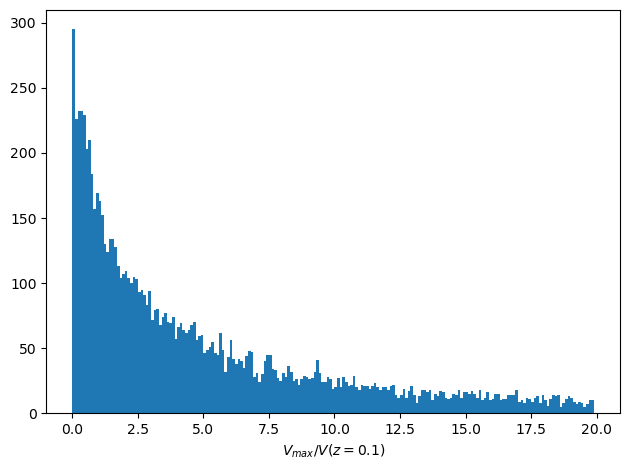

In [6]:
plt.figure(tight_layout=True)

plt.hist(sgatab['MAX_VOL_FRAC'], np.arange(0, 20, 0.1))

plt.xlabel('$V_{max}$/$V(z = 0.1)$');

## Convert to CMB frame

In [7]:
sgatab['Z_DESI_CMB'] = convert_z_frame(sgatab['Z_DESI'], sgatab['RA'], sgatab['DEC'])

# Load Morphological Classification

## SSL

As an alternative to morphological classification of the galaxies, we also produced a classification based on the SSL sorter (using a nearest-neighbor query; Largett et al., in prep.). The classification ignored the Hubble sub-types and grouped the galaxies into four main categories:
1. Spiral
2. Elliptical
3. Lenticular
4. Irregular

Let's also load this table and add it to the SGA table.

In [8]:
# ai_morphpath = '/global/cfs/cdirs/desi/science/td/pv'
ai_morphpath = '.'
# ai_morphpath = '/global/cfs/cdirs/desi/science/td/pv/SGA2020'
# ai_morphcsv = os.path.join(ai_morphpath, 'sga10278_morphologies_model_analysis.csv')
ai_morphcsv = os.path.join(ai_morphpath, 'TFY1_Classification.csv')

ai_morphtab = Table.read(ai_morphcsv)
ai_morphtab

SGA_ID,Spiral_Pred,Elliptical_Pred,Lenticular_Pred,Irregular_Pred
float64,str6,str10,str10,str9
2371.0,Other,Other,Other,Irregular
2406.0,Spiral,Other,Other,Other
4614.0,Spiral,Other,Other,Other
7707.0,Spiral,Other,Other,Other
8119.0,Spiral,Other,Other,Other
8832.0,Spiral,Other,Other,Other
9415.0,Other,Other,Other,Irregular
11933.0,Spiral,Other,Other,Other
12347.0,Other,Other,Other,Irregular


In [9]:
# Create an overall record of the SSL prediction
ai_morphtab['Predicted_Type'] = 'Undecided '

for i in range(len(ai_morphtab)):
    
    classes = ai_morphtab['Spiral_Pred', 'Elliptical_Pred', 'Lenticular_Pred', 'Irregular_Pred'][i]
    
    ai_morphtab['Predicted_Type'][i] = next(j for j in classes if j != 'Other')

### Combine ML morphtypes with SGA catalog

In [10]:
sgatab = join(sgatab, ai_morphtab['SGA_ID', 'Predicted_Type'], keys='SGA_ID', join_type='left')

# Rename Predicted_Type to MORPHTYPE_AI
sgatab['Predicted_Type'].name = 'MORPHTYPE_AI'

## John Lucey's VI results

https://astro.dur.ac.uk/~jrl/DESI_TF_Y1/index.html

We are only considering galaxies that he considers bad for TF (strong asymmetry, double galaxies, stellar contamination).

In [11]:
lucey_VIpath = 'VI_JohnLucey/'

rejects = lucey_VIpath + 'REJECTS.txt'

reject_tab = Table.read(rejects, format='ascii.commented_header')
reject_tab['VI'] = 'reject'
reject_tab

SGA_ID,DESI_NAME,RA,Dec,z_desi,V_0p4R26,V_0p4R26_err,V_PEC,V_ERR_PEC,VI
int64,str22,float64,float64,float64,int64,int64,int64,int64,str6
18171,DESIXJ21105773+0109527,317.74056,1.164637,0.0903,219,1,-555,542,reject
18900,DESIXJ13403122+0437086,205.130097,4.619043,0.0224,52,2,2647,351,reject
20828,DESIXJ20452158-0505449,311.339907,-5.095804,0.0522,97,1,9894,335,reject
24403,DESIXJ13023920-0257343,195.663329,-2.959515,0.0675,222,1,-2594,411,reject
34318,DESIXJ15173290+0109051,229.38709,1.151405,0.1257,235,38,7564,7706,reject
43314,DESIXJ19180598+6436397,289.524898,64.611027,0.0255,104,2,1327,299,reject
61768,DESIXJ23195165+0025234,349.965218,0.423153,0.0341,123,0,-305,278,reject
63092,DESIXJ14161558-0127527,214.064897,-1.46464,0.0363,149,0,-5767,286,reject
65921,DESIXJ21443087-0617367,326.12863,-6.293535,0.09,89,21,26924,8751,reject


### Combine John's results with Y1 TF sample

In [12]:
sgatab = join(sgatab, reject_tab['SGA_ID', 'VI'], keys='SGA_ID', join_type='left')

# Rename VI column to JOHN_VI
sgatab['VI'].name = 'JOHN_VI'

In [13]:
sgatab[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_ERR,PHOTSYS,D26_kpc,DIST_MAX,MAX_VOL_FRAC,Z_DESI_CMB,MORPHTYPE_AI,JOHN_VI
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,kpc,kpc,,,,
float64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes1,float64,float64,float64,float64,str10,str6
38.0,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,18.566164,17.886087,17.47688,18.383362,17.749825,17.355968,18.261652,17.655558,17.284552,18.168955,17.588947,17.231817,18.101948,17.547142,17.20673,18.055267,17.516266,17.18719,18.023865,17.497095,17.178627,0.041267984,0.058114093,0.082968995,0.08808186,0.099526815,0.11876543,0.11355961,0.14645264,0.17035669,0.028041152,0.045385383,0.052895926,0.02822557,0.041093465,0.04698563,0.027371243,0.038240846,0.043213904,0.026219657,0.03618844,0.04070005,0.025270721,0.034526117,0.039107796,0.024264116,0.033164512,0.03780495,0.02343744,0.03226152,0.037176747,0.022813411,0.031564914,0.036686495,0.022342678,0.031088097,0.03649375,17.87426,0.761488

# Photometric corrections

### Survey offsets

In [15]:
sys_corr, sys_corr_err = BASS_corr(sgatab['PHOTSYS'])

### MW dust corrections

In [16]:
# Import E(B-V) dust map
# ebv_directory = '/global/cfs/cdirs/desicollab/users/rongpu/dust/desi_ebv/public_data/maps/'
ebv_directory = '/Users/kdouglass/Documents/Research/data/DESI/'
ebv_filename = 'desi_dust_gr_512.fits'
ebv_map = Table.read(ebv_directory + ebv_filename)

In [17]:
MWdust_corr, MWdust_corr_err = MW_dust(sgatab['RA'], sgatab['DEC'], ebv_map)

/Users/kdouglass/Documents/Research/DESI/PV_survey/code/TF/TF_photoCorrect.py:90: UserWarning: Warning: converting a masked element to nan.
  EBV_err[i] = ebv_map['EBV_GR_ERR'][i_ebv]


In [18]:
# Flip NaN values to 0
MWdust_corr_err[np.isnan(MWdust_corr_err)] = 0

### $K$-corrections

In [19]:
# Apparently we have some galaxies with negative redshifts
zg0 = sgatab['Z_DESI'] >= 0

In [20]:
kcorr_zg0 = k_corr(sgatab['Z_DESI'][zg0], 
                   [sgatab['G_MAG_SB26'][zg0], sgatab['R_MAG_SB26'][zg0], sgatab['Z_MAG_SB26'][zg0]], 
                   [sgatab['G_MAG_SB26_ERR'][zg0], sgatab['R_MAG_SB26_ERR'][zg0], sgatab['Z_MAG_SB26_ERR'][zg0]], 
                   z_corr=0.1) # K-correcting to same redshift as FastSpecFit (which is what Caitlin's using for the FP)

In [21]:
kcorr = np.zeros([len(sgatab), 3])
kcorr[zg0] = kcorr_zg0

### Internal dust extinction correction

This is based off of a linear fit to ($b/a$, $m_r$), removing any correlation between $b/a$ and $m_r$.

In [22]:
temp_infile = open('iron_internalDust_z0p1_mcmc.pickle', 'rb')
dust_mcmc_samples_r,_, dust_mcmc_samples_g,_, dust_mcmc_samples_z,_ = pickle.load(temp_infile)
temp_infile.close()

In [23]:
internalDust_coeffs_r = np.median(dust_mcmc_samples_r, axis=1)
internalDust_coeffs_g = np.median(dust_mcmc_samples_g, axis=1)
internalDust_coeffs_z = np.median(dust_mcmc_samples_z, axis=1)

internalDust_coeffs_err_r = np.zeros(len(internalDust_coeffs_r))
internalDust_coeffs_err_g = np.zeros(len(internalDust_coeffs_g))
internalDust_coeffs_err_z = np.zeros(len(internalDust_coeffs_z))

internalDust_coeffs_err_r[0] = np.std(dust_mcmc_samples_r[0][(-1.5 < dust_mcmc_samples_r[0]) & (dust_mcmc_samples_r[0] < 0)])
internalDust_coeffs_err_r[1] = np.std(dust_mcmc_samples_r[1][(0 < dust_mcmc_samples_r[1]) & (dust_mcmc_samples_r[1] < 1)])

internalDust_coeffs_err_g[0] = np.std(dust_mcmc_samples_g[0][(-1.5 < dust_mcmc_samples_g[0]) & (dust_mcmc_samples_g[0] < 0)])
internalDust_coeffs_err_g[1] = np.std(dust_mcmc_samples_g[1][(0 < dust_mcmc_samples_g[1]) & (dust_mcmc_samples_g[1] < 1)])

internalDust_coeffs_err_z[0] = np.std(dust_mcmc_samples_z[0][(-1.5 < dust_mcmc_samples_z[0]) & (dust_mcmc_samples_z[0] < 0)])
internalDust_coeffs_err_z[1] = np.std(dust_mcmc_samples_z[1][(0 < dust_mcmc_samples_z[1]) & (dust_mcmc_samples_z[1] < 1)])

In [24]:
internalDust_corr_r, internalDust_corr_err_r = internal_dust(sgatab['BA'], 
                                                             internalDust_coeffs_r, 
                                                             internalDust_coeffs_err_r)

internalDust_corr_g, internalDust_corr_err_g = internal_dust(sgatab['BA'], 
                                                             internalDust_coeffs_g, 
                                                             internalDust_coeffs_err_g)

internalDust_corr_z, internalDust_corr_err_z = internal_dust(sgatab['BA'], 
                                                             internalDust_coeffs_z, 
                                                             internalDust_coeffs_err_z)

## Apply corrections

In [25]:
sgatab['G_MAG_SB26_CORR'] = sgatab['G_MAG_SB26'] - MWdust_corr[0] + sys_corr + kcorr[:,0] - internalDust_corr_g
sgatab['R_MAG_SB26_CORR'] = sgatab['R_MAG_SB26'] - MWdust_corr[1] + sys_corr + kcorr[:,1] - internalDust_corr_r
sgatab['Z_MAG_SB26_CORR'] = sgatab['Z_MAG_SB26'] - MWdust_corr[2] + sys_corr + kcorr[:,2] - internalDust_corr_z

In [26]:
sgatab['G_MAG_SB26_ERR_CORR'] = np.sqrt(sgatab['G_MAG_SB26_ERR']**2 + MWdust_corr_err[0]**2 + sys_corr_err**2 + internalDust_corr_err_g**2)
sgatab['R_MAG_SB26_ERR_CORR'] = np.sqrt(sgatab['R_MAG_SB26_ERR']**2 + MWdust_corr_err[1]**2 + sys_corr_err**2 + internalDust_corr_err_r**2)
sgatab['Z_MAG_SB26_ERR_CORR'] = np.sqrt(sgatab['Z_MAG_SB26_ERR']**2 + MWdust_corr_err[2]**2 + sys_corr_err**2 + internalDust_corr_err_z**2)

# Apply Cuts Suitable for Calibrating the TFR

Requirements:
* $10~\mathrm{km/s} < V_\mathrm{rot} < 1000~\mathrm{km/s}$ at $0.4R_{26}$
* $\Delta V/V_\mathrm{min} \leq 5$
* Passed visual inspection (both ours and John Lucey's)
* $i > 45^\circ$
* Spiral-type morphology
* Not an outlier (as found in the `TF_Y1_clustering.ipynb` notebook)

The first 2.5 items have already been applied (our VI results have already been applied, but not John's).

In [27]:
sgatab['MU_ZCMB'] = Planck18_h.distmod(sgatab['Z_DESI_CMB'])

sgatab['R_ABSMAG_SB26'] = sgatab['R_MAG_SB26_CORR'] - sgatab['MU_ZCMB'].value

data = np.array([sgatab['R_ABSMAG_SB26'], np.log10(sgatab['V_0p4R26'])])

clusterer = HDBSCAN(cluster_selection_epsilon=0.07)

clusterer.fit(data.T)

outlier_boolean = clusterer.labels_ != 12
# This limit was determined in the TF_Y1_clustering.ipynb notebook

In [28]:
#- Inclination cut
cosi2 = (sgatab['BA']**2 - q0**2) / (1 - q0**2)
i_min = 45. * u.degree
cosi2_max = np.cos(i_min)**2
is_good_incl = cosi2 < cosi2_max

#- Morphology cut: only ML
is_good_morph_ML = np.zeros_like(is_good_incl, dtype=bool)
for i in range(len(sgatab)):
    if sgatab['MORPHTYPE_AI'][i] == 'Spiral':
        is_good_morph_ML[i] = True

#- John's VI
is_good_John = sgatab['JOHN_VI'].mask

#- Combine selections:
is_good_sga = is_good_incl & is_good_morph_ML & is_good_John & ~outlier_boolean

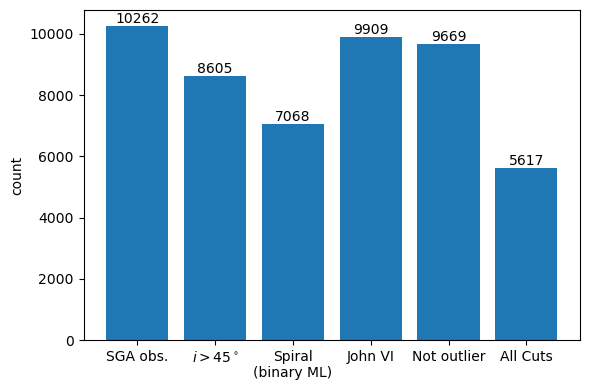

In [29]:
data = {
    'SGA obs.' : len(sgatab),
    # r'$10 < V_\mathrm{rot} < 1000$' : np.sum(is_good_velo),
    # r'$\Delta V/V_\mathrm{min}>5$' : np.sum(is_good_dv),
    r'$i > 45^\circ$' : np.sum(is_good_incl), 
    # 'Spiral' : np.sum(is_good_morph),
    'Spiral\n(binary ML)' : np.sum(is_good_morph_ML),
    'John VI' : np.sum(is_good_John), 
    # 'Not dwarf' : np.sum(~dwarf_boolean), 
    'Not outlier' : np.sum(~outlier_boolean), 
    'All Cuts' : np.sum(is_good_sga), 
    # 'All Cuts\n(binary ML)' : np.sum(is_good_sga_ML)
}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(1, 1, figsize=(6,4), tight_layout=True)
bars = ax.bar(names, values, color='tab:blue')
ax.bar_label(bars, fmt='%d')
ax.set(ylabel='count');#, yscale='log', ylim=[1e3,1.2e4]);

# fig.savefig('../../Figures/Y1/TF_Y1_SGA_Vrot_cuts.png', dpi=150, facecolor='none');

# Redshift bins

Separate the galaxies into redshift bins of width 0.005, starting at a redshift of 0.03.  (PVs are a significant fraction of the redshift at redshifts less than this.)

In [30]:
zmin = 0.03
zmax = 0.1
dz = 0.005
zbins = np.arange(zmin, zmax + dz, dz)

#- SGA galaxies that passed quality selection
sgatab_sel = sgatab[is_good_sga]

zbin_indices = np.digitize(sgatab_sel['Z_DESI_CMB'], zbins, right=True)

In [31]:
for i in range(len(zbins) + 1):
    if i == 0:
        print(f'{i:2d}  z <= {zbins[i]:0.3f}  {np.sum(zbin_indices == i):3d} galaxies')
    elif i == len(zbins):
        print(f'{i:2d}  z > {zbins[i-1]:0.3f}  {np.sum(zbin_indices == i):3d} galaxies')
    else:
        print(f'{i:2d}  {zbins[i-1]:0.3f} < z <= {zbins[i]:0.3f}  {np.sum(zbin_indices == i):3d} galaxies')

 0  z <= 0.030  668 galaxies
 1  0.030 < z <= 0.035  412 galaxies
 2  0.035 < z <= 0.040  343 galaxies
 3  0.040 < z <= 0.045  348 galaxies
 4  0.045 < z <= 0.050  365 galaxies
 5  0.050 < z <= 0.055  368 galaxies
 6  0.055 < z <= 0.060  317 galaxies
 7  0.060 < z <= 0.065  347 galaxies
 8  0.065 < z <= 0.070  328 galaxies
 9  0.070 < z <= 0.075  305 galaxies
10  0.075 < z <= 0.080  305 galaxies
11  0.080 < z <= 0.085  311 galaxies
12  0.085 < z <= 0.090  254 galaxies
13  0.090 < z <= 0.095  171 galaxies
14  0.095 < z <= 0.100  126 galaxies
15  0.100 < z <= 0.105  137 galaxies
16  z > 0.105  512 galaxies


In [32]:
_, counts = np.unique(zbin_indices, return_counts=True)

print(np.min(counts[1:-1]), np.max(counts[1:-1]))

126 412


# Build the Calibration Table of SGA Galaxies

In [33]:
sgatab_sel['Z_BIN_IDX'] = zbin_indices

no_use = (zbin_indices == 0) | (zbin_indices == len(zbins))
caltab = sgatab_sel[~no_use]

rejtab = sgatab_sel[no_use]

# caltab.write('SGA-2020_iron_Vrot_cluster_calib_z0p1_Anthony2_dVsys.fits', overwrite=True)
caltab[['Z_BIN_IDX', 'Z_DESI_CMB', 'SGA_ID', 'R_MAG_SB26_CORR', 'R_MAG_SB26_ERR_CORR', 'V_0p4R26', 'V_0p4R26_ERR']]

Z_BIN_IDX,Z_DESI_CMB,SGA_ID,R_MAG_SB26_CORR,R_MAG_SB26_ERR_CORR,V_0p4R26,V_0p4R26_ERR
int64,float64,float64,float64,float64,float64,float64
11,0.08162327483927467,38.0,16.728901859968826,0.1097937894913965,122.3223893029039,9.671537005812278
13,0.09120074612338591,117.0,15.954404164953896,0.11303674793725518,180.6557315191658,12.555107762887319
4,0.04770393135250317,1158.0,14.818769372779832,0.10821215985133983,177.66056756020413,9.72984498796923
2,0.03730090242889217,1289.0,15.155128632881553,0.13607703864259116,69.54198306734067,26.742366851179067
6,0.05517343391109497,1358.0,14.473279316226737,0.06547763495568182,199.7389320074389,7.021351014635882
7,0.0621114746308149,1548.0,16.460548734077033,0.09659160140251052,169.13249529335522,9.834260346331956
6,0.05541189869150731,1663.0,16.26892285369704,0.1353047625643276,140.65283727627954,9.956496209244492
10,0.07868601783175921,1849.0,15.21134799027916,0.07192519421227364,224.4427647941615,10.276851054314735
4,0.048805933559745496,1996.0,16.692477275806624,0.08932478640546558,125.9470302632088,10.746649525209024


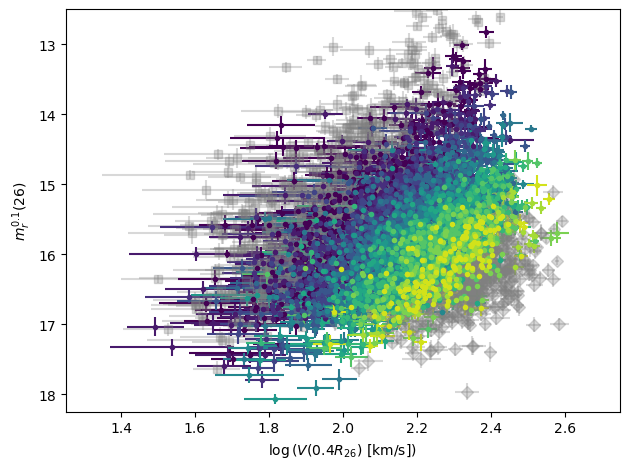

In [37]:
# fig, axes = plt.subplots(1, 2, figsize=(8,6), sharex=True, tight_layout=True)
fig, axes = plt.subplots(1, 1, tight_layout=True)

logV0 = 0

# ax = axes[0] 
ax = axes

#-------------------------------------------------------------------------------
# Plot galaxies with failed cluster selections.
#-------------------------------------------------------------------------------
_zbin_ids = np.unique(rejtab['Z_BIN_IDX'])
markers = 'sDv^<>'
for j, _zbin_id in enumerate(_zbin_ids):
    select_zbin = np.isin(rejtab['Z_BIN_IDX'], _zbin_id)

    #- Store independent variable for each cluster
    logv = np.log10(rejtab['V_0p4R26'][select_zbin].data) - logV0
    logv_err = 0.434*rejtab['V_0p4R26_ERR'][select_zbin].data / rejtab['V_0p4R26'][select_zbin].data

    #- Store dependent variable for each cluster
    mr26 = rejtab['R_MAG_SB26_CORR'][select_zbin].data
    mr26_err = rejtab['R_MAG_SB26_ERR_CORR'][select_zbin].data

    if _zbin_id == 0:
        ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, 
                    fmt=markers[j % 2], markersize=6, color='gray', alpha=0.3, 
                    label=f'z $\leq$ {zbins[_zbin_id]:.3f} (rej.)')
    else:
        ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, 
                    fmt=markers[j % 2], markersize=6, color='gray', alpha=0.3, 
                    label=f'z > {zbins[_zbin_id-1]:.3f} (rej.)')
#-------------------------------------------------------------------------------
# Plot galaxies and clusters passing all selections.
#-------------------------------------------------------------------------------
_zbin_ids = np.unique(caltab['Z_BIN_IDX'])

plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.viridis(np.linspace(0,1,len(_zbin_ids)+1)))

for _zbin_id in _zbin_ids:
    select_zbin = np.isin(caltab['Z_BIN_IDX'], _zbin_id)

    #- Store independent variable for each cluster
    logv = np.log10(caltab['V_0p4R26'][select_zbin].data) - logV0
    logv_err = 0.434*caltab['V_0p4R26_ERR'][select_zbin].data / caltab['V_0p4R26'][select_zbin].data

    #- Store dependent variable for each cluster
    mr26 = caltab['R_MAG_SB26_CORR'][select_zbin].data
    mr26_err = caltab['R_MAG_SB26_ERR_CORR'][select_zbin].data
    
    ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, fmt='.', 
                label=f'{zbins[_zbin_id-1]:.3f}-{zbins[_zbin_id]:.3f}')
#-------------------------------------------------------------------------------

ax.set(xlim=[1.25, 2.75],
       xlabel=r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)',
       ylim=[18.25, 12.5],
       ylabel=r'$m_r^{0.1} (26)$');

# fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_0pt_binaryMLupdated_20241203.png', dpi=150);

# Apply the Joint TFR Fit

In [38]:
#- Extract successful clusters
_zbin_ids = np.unique(caltab['Z_BIN_IDX'])
m = len(_zbin_ids)

#- Pack the results into arrays data and cov.
logV, logV_err = [], []
mag, mag_err = [], []
weights = []

logV0 = np.median(np.log10(caltab['V_0p4R26']))
print('logV0 =', logV0)

#- Loop over the redshift bins
for k, _zbin_id in enumerate(_zbin_ids):
    select_zbin = np.isin(caltab['Z_BIN_IDX'], _zbin_id)
    logV.append(np.log10(caltab['V_0p4R26'][select_zbin]) - logV0)
    logV_err.append(0.434*caltab['V_0p4R26_ERR'][select_zbin] / caltab['V_0p4R26'][select_zbin])
    mag.append(caltab['R_MAG_SB26_CORR'][select_zbin])
    mag_err.append(caltab['R_MAG_SB26_ERR_CORR'][select_zbin])
    weights.append(np.array(1/caltab['MAX_VOL_FRAC'][select_zbin]))

logV0 = 2.1768051813695144


## Multiline Fit using HyperFit

In [39]:
bounds = [[-20, 0]]                    # Bounds on a (slope)
bounds += m*[(-20, 20)]                # Bounds on b (intercepts: z-bins)
bounds += [(0,5)]                      # Bounds on sigma

results = hyperfit_line_multi(logV, mag, logV_err, mag_err, bounds, weights=weights, scatter=1)

a, b, sig_tfr, cov_tfr, tfr_mcmc_samples, hf_tfr = results

             message: Optimization terminated successfully.
             success: True
                 fun: -1085536.6244282885
                   x: [-6.563e+00  1.448e+01 ...  1.686e+01  4.407e-01]
                 nit: 178
                nfev: 46023
          population: [[-6.565e+00  1.448e+01 ...  1.687e+01  4.410e-01]
                       [-6.567e+00  1.448e+01 ...  1.687e+01  4.410e-01]
                       ...
                       [-6.566e+00  1.448e+01 ...  1.687e+01  4.408e-01]
                       [-6.567e+00  1.448e+01 ...  1.689e+01  4.408e-01]]
 population_energies: [-1.086e+06 -1.086e+06 ... -1.086e+06 -1.086e+06]
                 jac: [ 3.562e+00  1.746e+01 ...  1.071e+00  2.445e+01]
Ndim: 17 15


100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 58.28it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [67.75449177 52.98105563 54.88386327 60.58322307 72.01257338 58.14899433
 64.13282893 57.37916961 80.71229608 58.78965615 80.86494969 72.34541572
 64.49193661 71.7133548  74.60439564 69.06626744 73.71979538] / 4043.247484277765


100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 57.56it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [ 98.86942047  50.22634376  61.05523124  67.33220919  66.929365
  68.75200621  77.38567912  67.87002766  75.69139821  82.17147195
  86.08735256  76.06490152  87.51469069  96.44912842  95.19588979
  81.47180489 103.35149452] / 5167.574725779282


100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 57.13it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [109.95264208  46.03954573  62.1906637   69.40634385  61.24215794
  68.68840133  83.69694694  81.79984526  76.94569532  84.87827206
  93.33556836  93.75349692  94.86345797  98.17189083  87.55051348
  98.91267377 104.89559985] / 5497.632103785978


100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.96it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [116.23877205  51.58726657  61.98092261  72.98085224  67.447711
  82.13795663  84.01975716  84.30358589  87.06653379  91.09234632
  93.32224537 114.69584317  97.98456211 105.30162253  95.58200455
 112.21374917 105.32503174] / 5811.938602375166


100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.42it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [118.71199511  51.4574893   66.66765227  79.64511004  67.71749177
  76.55282066  85.06242342  91.07576063  86.32299289  96.55637541
  96.08936365 123.2577344  103.77977214 104.76328601 110.56439257
 121.50772641 116.79976223] / 6162.8867199531005


100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 57.15it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [124.10113614  53.26606558  72.80297526  77.15098412  74.48619965
  79.43091808  85.62750107  87.38834397  90.25060259  97.82865251
  92.62796214 103.0656392  106.58475761 110.34053326 120.11111346
 144.53727165 119.71137798] / 7226.863582355622


100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 57.04it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [139.05316367  52.58220333  76.76022461  76.63573821  77.73928152
  80.72199263  82.02464182  89.91506616  93.96604577  94.87524664
  98.27079356 107.08950294 109.99075277 128.69214896 136.37274999
 142.58880576 119.51944894] / 7129.44028781102


100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 57.14it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [139.16043534  55.13614772  80.9968298   79.74060918  82.23231078
  88.52516853  84.13324125  98.13818696  99.57203825  98.08834088
  99.78154963 103.99207477 111.92428775 128.34613134 137.95059101
 152.77051422 120.5058048 ] / 7638.52571108518


100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 57.01it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [140.02226639  57.40253637  77.89083037  78.39037328  79.23373903
  96.32828045  86.31223974 100.73573671 105.17923541 100.04920839
 104.5598557  102.74660293 115.40910135 141.35497885 135.74640464
 157.61722008 130.78101967] / 7880.861003942659


100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.98it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [143.35801091  55.08730996  77.98511926  80.73726168  83.29745374
  97.75128584  85.72341237 101.07029592 107.2724719  101.2129775
 109.86343817 105.47909312 121.59088624 149.27780595 137.78639033
 157.45475444 139.42902875] / 7872.737721854133


100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.80it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [153.07156999  54.20555756  76.86550943  80.46756991  81.14682652
  93.05140788  87.54223784 102.03216896 113.38934492 109.67145344
 105.88805811 114.50398647 126.76759982 154.83501747 134.39463134
 162.04133059 148.22202331] / 8102.066529684964


100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 57.01it/s]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [155.25049273  55.59095531  76.30410013  81.95906061  80.38854933
  91.61729465  87.72081659 100.23779835 111.00704895 110.53642685
 104.42739199 119.24834405 127.86509738 155.13340436 132.30883571
 154.42241661 152.77792287] / 7762.524636566613


In [40]:
temp_outfile = open('cov_ab_iron_jointTFR_HDBSCAN_z0p1_zbins0p005_weightsVmax-1_dVsys_KAD-20250810.pickle', 
                    'wb')
pickle.dump((cov_tfr, tfr_mcmc_samples, logV0, zmin, zmax, dz, zbins), temp_outfile)
temp_outfile.close()

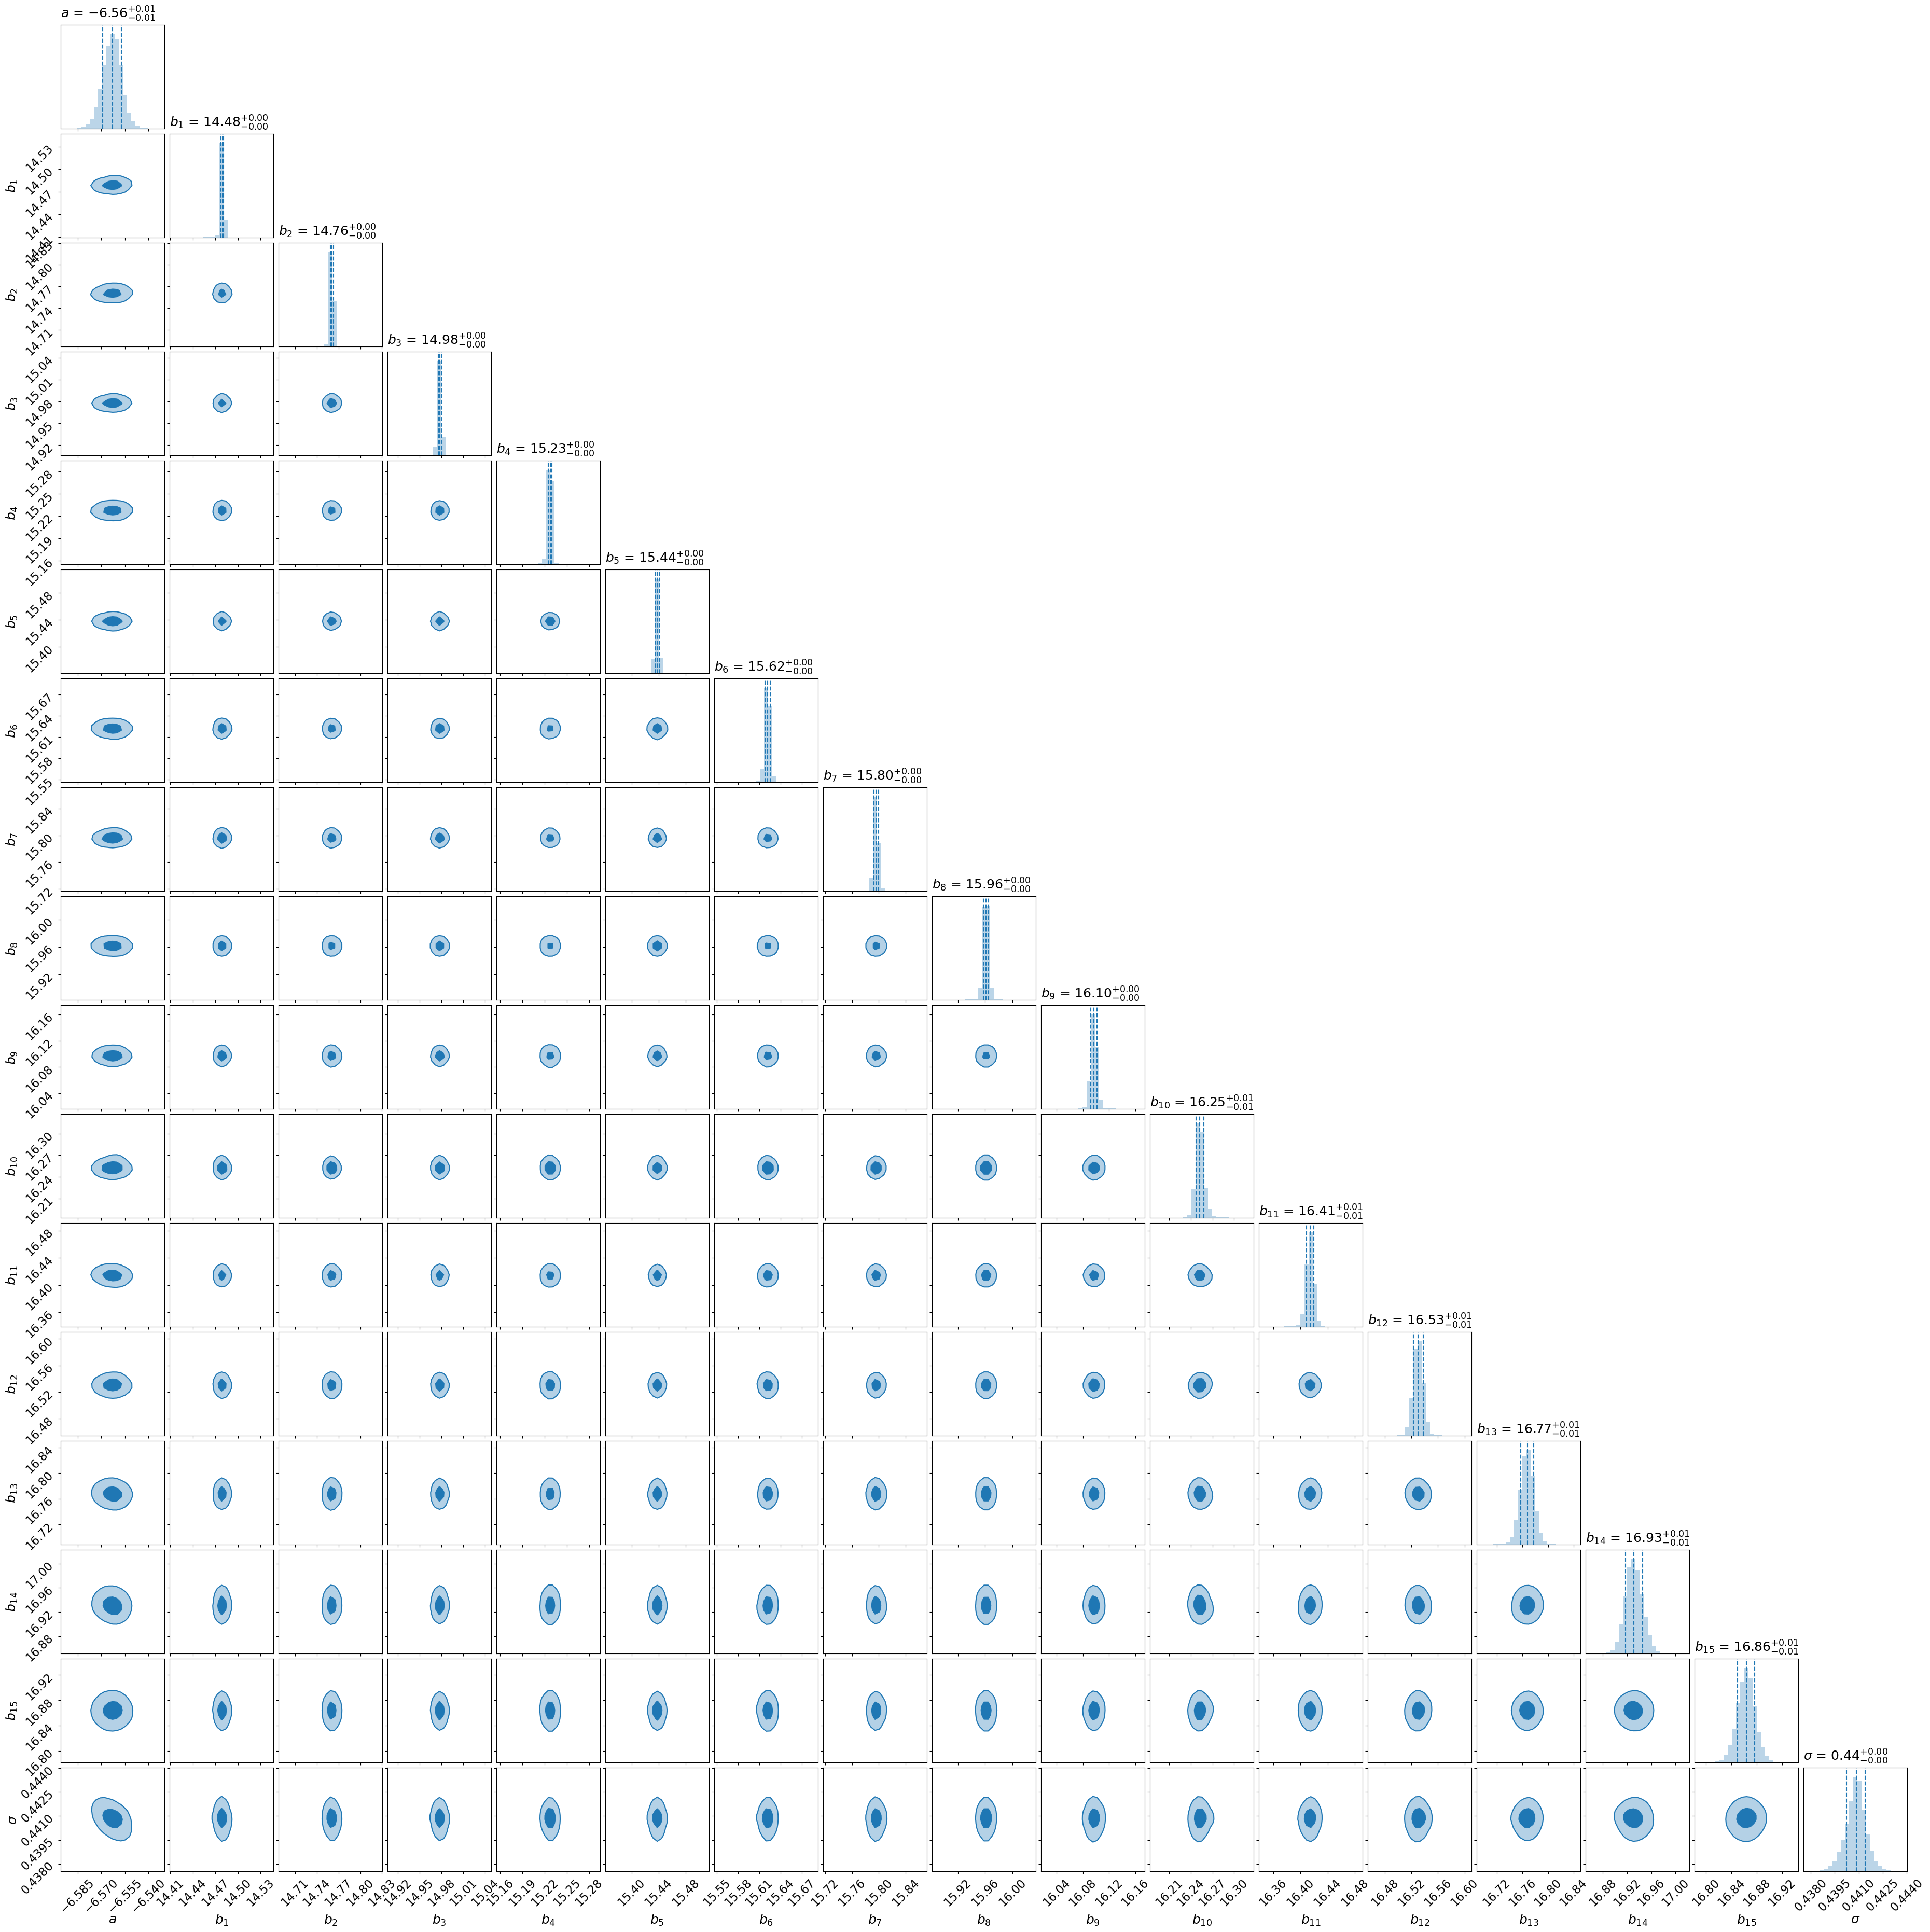

In [41]:
labels  = ['$a$']
labels += [f'$b_{{ {k+1} }}$' for k in np.arange(m)]
labels += [r'$\sigma$'] #+ [rf'$\sigma_{k}$' for k in np.arange(m)]

fig = corner(tfr_mcmc_samples.T, bins=25, smooth=1,
#              range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=labels,
             label_kwargs={'fontsize':18},
             labelpad=0.1,
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='tab:blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});

for ax in fig.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=16)

# fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_binaryMLupdated_z0p1_Anthony2_weightsVmax-1_dVsys_corner0_20250717.png', 
#             dpi=150, 
#             facecolor='none');

### Plot the HyperFit Results

In [42]:
sigma_mcmc = np.percentile(tfr_mcmc_samples[-1], [16., 50., 84.])
a_mcmc = np.percentile(tfr_mcmc_samples[0], [16., 50., 84])
b_mcmc = []
# for k in range(1, m+2):
for k in range(1, m+1):
    b_mcmc.append(np.percentile(tfr_mcmc_samples[k], [16., 50., 84.]))
b_mcmc = np.asarray(b_mcmc)

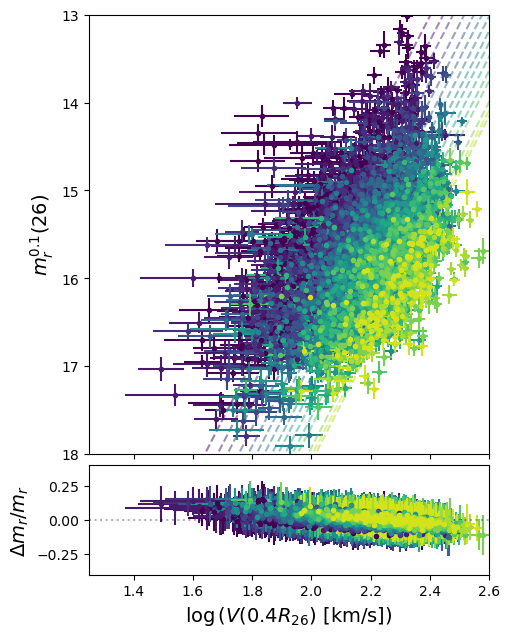

In [43]:
# fig, axes = plt.subplots(2,2, figsize=(10,7), sharex=True,
fig, axes = plt.subplots(2,1, figsize=(5,7), sharex=True,
                         gridspec_kw={'height_ratios':[4,1], 'hspace':0.04, 'wspace':0.25})

a_   = a_mcmc[1]
# b0pt = b_mcmc[0,1]
b_   = b_mcmc[:,1]#[1:]

#- Plot redshift bins
# ax = axes[0,0]
ax = axes[0]

plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.viridis(np.linspace(0,1,m)))

_logv = np.arange(0, 3, 0.1) - logV0
for k in range(m):
    eb = ax.errorbar(x=logV0 + logV[k],#+1], 
                     y=mag[k],#+1], 
                     xerr=logV_err[k],#+1], 
                     yerr=mag_err[k],#+1],
                     fmt='.', 
                     label=f'{zbins[k]:.3f}-{zbins[k+1]:.3f}')

    ax.plot(_logv + logV0, a_*_logv + b_[k], color=eb[0].get_color(), ls='--', alpha=0.5)

ax.set(xlim=[1.25, 2.6],
       ylim=[18, 13])
ax.set_ylabel(r'$m_r^{0.1} (26)$', fontsize=14)
# ax.legend(loc='upper left', fontsize=9, ncol=2);
'''
#- Plot calibrators
ax = axes[0,1]
eb = ax.errorbar(x=logV[0] + logV0, y=mag[0], xerr=logV_err[0], yerr=mag_err[0],
                 fmt='.', color='tab:blue', label=f'0-pt')

ax.plot(_logv + logV0, a_*_logv + b0pt, color=eb[0].get_color(), ls='--')#, label='fit')
ax.set(xlim=[1.25, 2.6],
       ylim=[-18, -24]
      )
ax.set_ylabel(r'$M_r^{0.1}(26) = m_r^{0.1}(26) - \mu$', fontsize=14)
ax.legend(loc='upper left', fontsize=9, ncol=2)
'''
#- Plot residuals: z-bins
# ax = axes[1,0]
ax = axes[1]

plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.viridis(np.linspace(0,1,m)))

for k in range(m):
    logv_obs = logV[k]#+1]
    m_obs = mag[k]#+1]
    m_exp = (a_*logv_obs + b_[k])
    eb = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, 
                     xerr=logV_err[k],#+1], 
                     yerr=mag_err[k],#+1],
                     fmt='.')

ax.axhline(0, ls=':', color='k', alpha=0.3)

ax.set(xlim=[1.25, 2.6],
       ylim=[-0.4, 0.4])
ax.set_xlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)', fontsize=14)
ax.set_ylabel(r'$\Delta m_r/m_r$', fontsize=14)
'''
#- Plot residuals: calibrators
ax = axes[1,1]

logv_obs = logV[0]
m_obs = mag[0]
m_exp = (a_*logv_obs + b0pt)

b = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, 
                xerr=logV_err[0], yerr=mag_err[0],
                fmt='.', color='tab:blue')
ax.axhline(0, ls=':', color='k', alpha=0.3)

ax.set(xlim=[1.25, 2.6],
       ylim=[-0.4, 0.4])
ax.set_xlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)', fontsize=14)
ax.set_ylabel(r'$\Delta M_r/M_r$', fontsize=14)
'''
fig.subplots_adjust(left=0.1, bottom=0.1, top=0.9, right=0.9);

# fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_0pt_binaryMLupdated_z0p1_Anthony2_weightsVmax-1_dVsys_fit0_20250717.png', 
#             dpi=150, 
#             facecolor='none')

In [44]:
print(f'slope (alpha): {-a_/2.5:.2f} +/- {np.sqrt(cov_tfr[0,0])/2.5:.3f}')

slope (alpha): 2.63 +/- 0.002


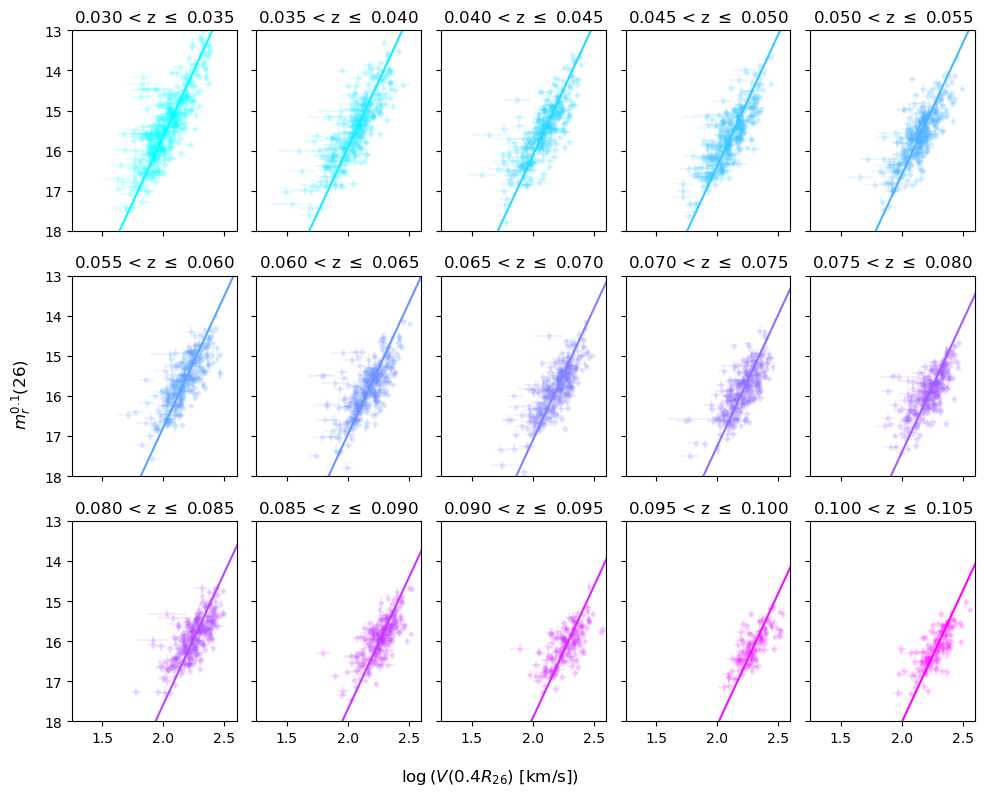

In [45]:
# fig, axs = plt.subplots(nrows=7, ncols=10, sharex=True, sharey=True, figsize=(20,16), tight_layout=True)
fig, axs = plt.subplots(nrows=3, ncols=5, sharex=True, sharey=True, figsize=(10,8), tight_layout=True)

color = iter(plt.cm.cool(np.linspace(0,1,m)))
for i in range(m):
    c = next(color)
    
    row = int(i/5)
    col = i%5
    
    eb = axs[row,col].errorbar(logV0 + logV[i],#+1], 
                               mag[i],#+1], 
                               xerr=logV_err[i],#+1], 
                               yerr=mag_err[i],#+1], 
                               fmt='.', color=c, alpha=0.1)
    axs[row,col].plot(_logv + logV0, a_*_logv + b_[i], color=c)
    
    axs[row,col].set(xlim=[1.25, 2.6], ylim=[18, 13], title=f'{zbins[i]:.3f} < z $\leq$ {zbins[i+1]:.3f}')

# Delete extra axes
# fig.delaxes(axs[-1,-1])

fig.supxlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)')
fig.supylabel(r'$m_r^{0.1} (26)$');

# plt.savefig('../../Figures/Y1/TF_Y1_individual_cluster_calibration_0pt_binaryMLupdated_z0p1_Anthony2_weightsVmax-1_dVsys_fit0_20250717.png', 
#             dpi=150, 
#             facecolor='none')